# Finite window bootstrap error

Estimate the error of our interior time estimator using bootstrapping for various trajectory counts.

## Variable definitions

In [35]:
import importlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats

import multi_locus_analysis as mla
import multi_locus_analysis.finite_window as fw
import multi_locus_analysis.plotting.finite_window as fplt
import bruno_util.plotting as bplt

figure_size = bplt.use_cell_style(mpl.rcParams)

In [2]:
from multi_locus_analysis.plotting import Variable
from scipy.stats import beta, expon, weibull_min
import seaborn as sns

variable_pairs = {}
windows = {}

# for Beta distributions, making the window size a little less than 1 guarantees there's not too many,
# and also not too fewobs per trajectory, so that the effect we want to show is visible
windows['beta'] = 0.8
variable_pairs['beta'] = [
    Variable(beta(5, 2), 
             name='Beta(5, 2)',
             pretty_name=r'Beta$(\alpha{}=5, \beta{}=2)$', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[2],
             scaled_ylim=4.0),
    Variable(beta(2, 2),
             name='Beta(2, 2)',
             pretty_name=r'Beta$(\alpha{}=2, \beta{}=2)$', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[3],
             scaled_ylim=2.0)
]


windows['exp'] = 2 + 4 + 2
variable_pairs['exp'] = [
    Variable(expon(scale=4), 
             name=f'Exp(4)', 
             linestyle=':', 
             color=sns.color_palette('colorblind')[4],
             scaled_ylim=0.3),
    Variable(expon(loc=2, scale=2), 
             name=f'Exp(2) + 2', 
             linestyle='--', 
             color=sns.color_palette('colorblind')[5],
             scaled_ylim=0.5)
]


windows['weibull'] = 10
variable_pairs['weibull'] = [
    Variable(
        weibull_min(c=0.5),
        name=r'W(1/2)',
        pretty_name=r'$W(1/2)$',
        linestyle=':', 
        color=sns.color_palette('colorblind')[2],
        scaled_ylim=2
    ),
    Variable(
        weibull_min(c=0.75),
        name=r'W(3/4)',
        pretty_name=r'$W(3/4)$',
        linestyle='--', 
        color=sns.color_palette('colorblind')[3],
        scaled_ylim=3
    )
    
]

## Examples across trajectory

In [15]:
Nboot_Ntraj = [(10**(6-k), 10**k) for k in [3, 4, 5]]
Nboot_Ntraj

[(1000, 1000), (100, 10000), (10, 100000)]

In [ ]:
%%time
err_aves = []
err_stds = []
for N_boot, N_traj_per_boot in Nboot_Ntraj:
    err_t, err_ave, err_std = fw.bootstrap_int_error(
        var_pair, T, N_boot, N_traj_per_boot
    )
    err_aves.append(err_ave)
    err_stds.append(err_std)

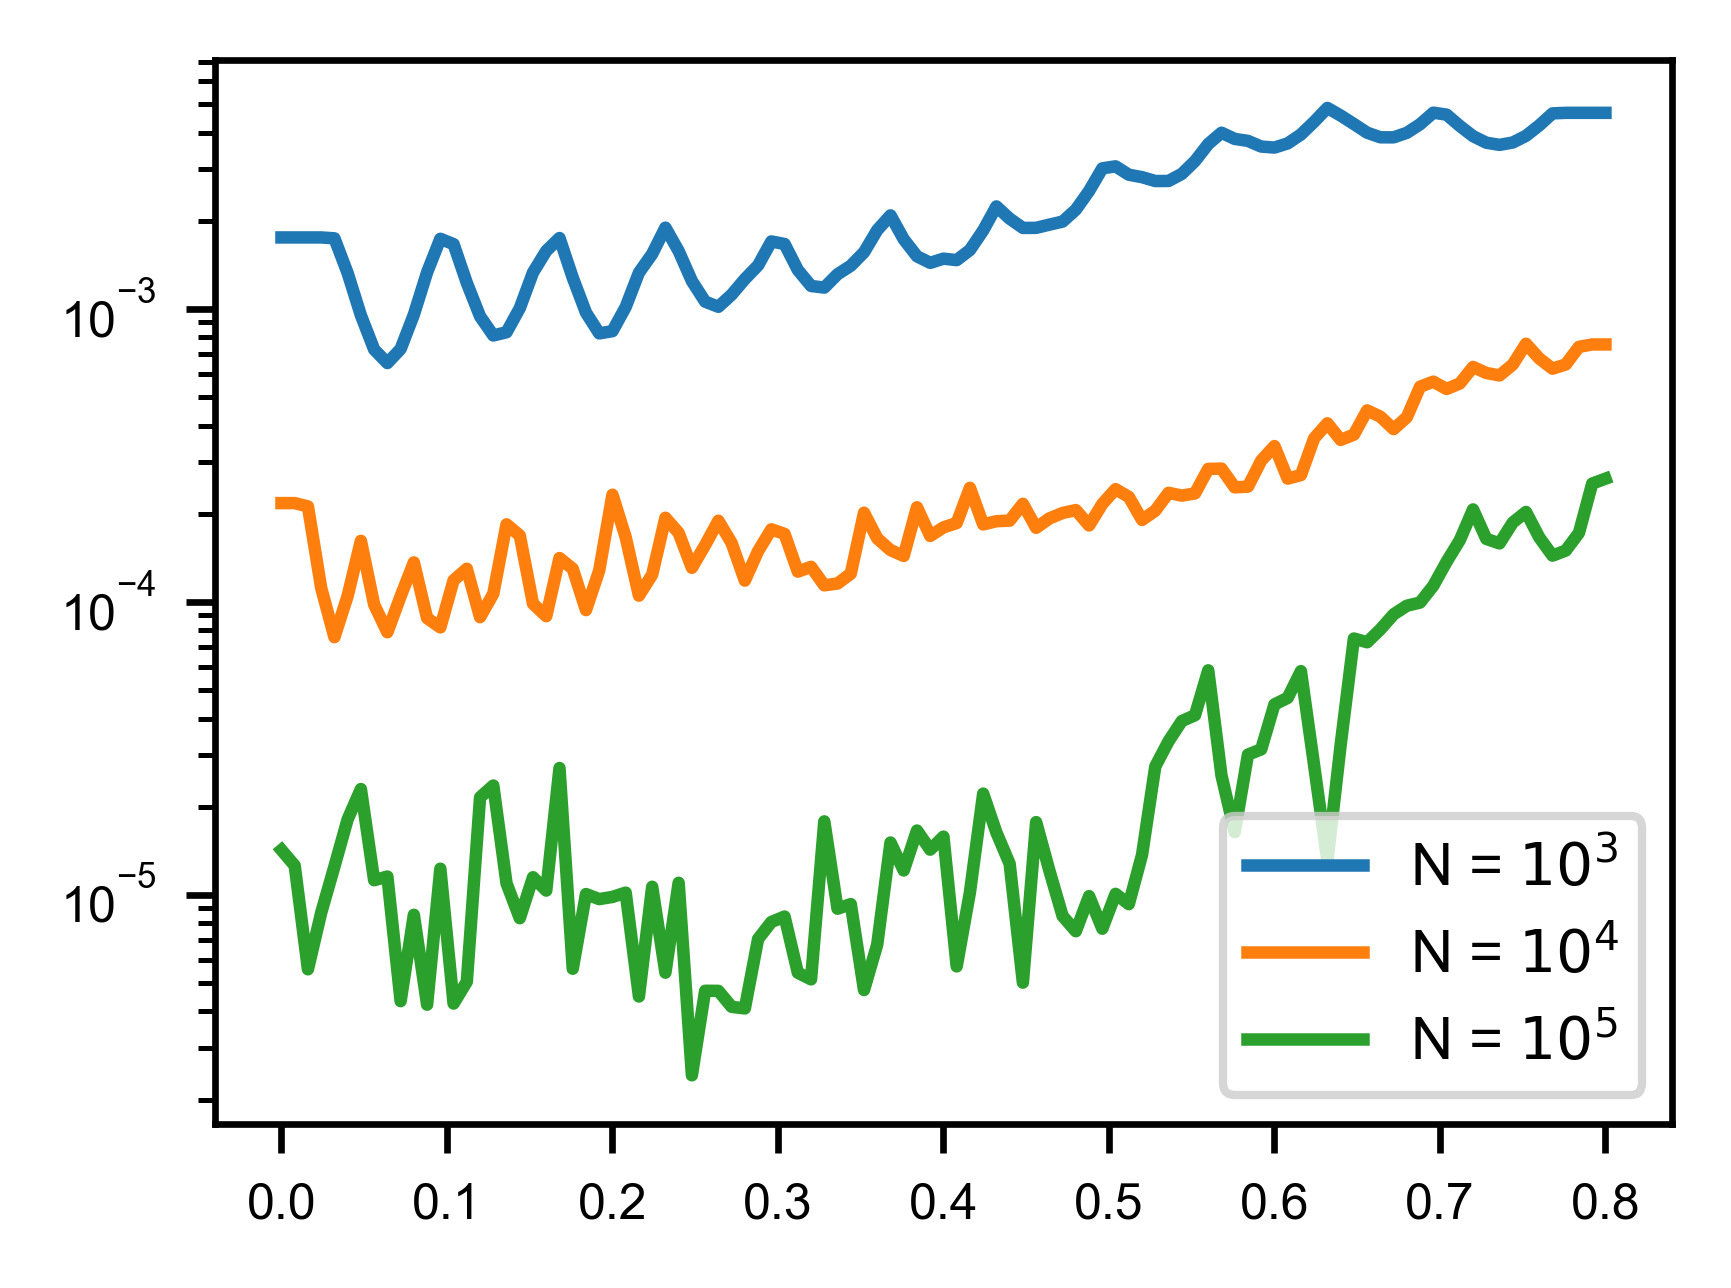

In [58]:
import matplotlib.pyplot as plt
for i, (N_boot, N_traj_per_boot) in enumerate(Nboot_Ntraj):
#     err_ave = err_aves[i]
    err_std = err_stds[i][var_pair[0].name]
    plt.plot(err_t, err_std, label=f'N = $10^{np.log10(N_traj_per_boot).astype(int)}$')
plt.yscale('log')
plt.legend()

In [ ]:
plt.plot(scipy)

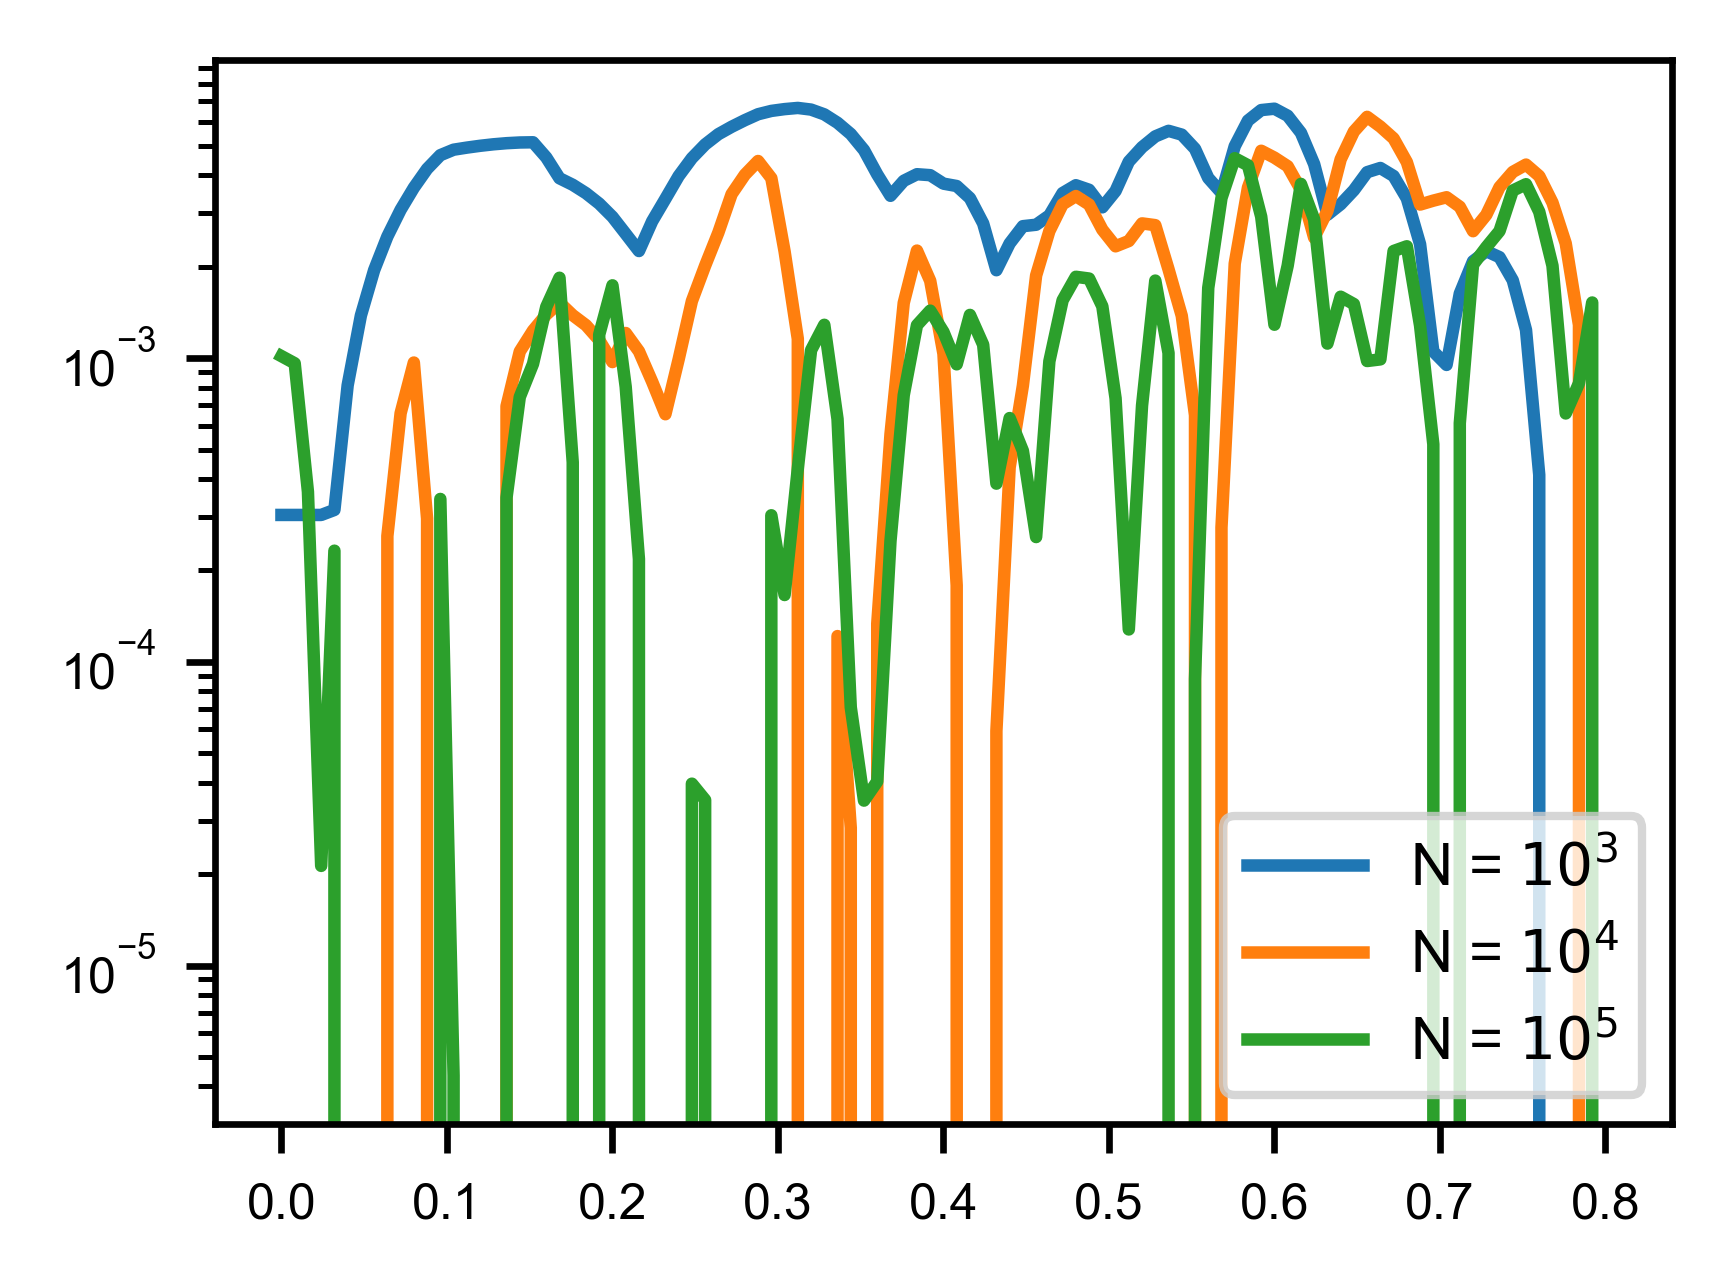

In [63]:
for i, (N_boot, N_traj_per_boot) in enumerate(Nboot_Ntraj):
    err_ave = err_aves[i][var_pair[0].name]
#     err_std = err_stds[i][var_pair[0].name]
    plt.plot(err_t, -err_ave, label=f'N = $10^{np.log10(N_traj_per_boot).astype(int)}$')
plt.yscale('log')
plt.legend()

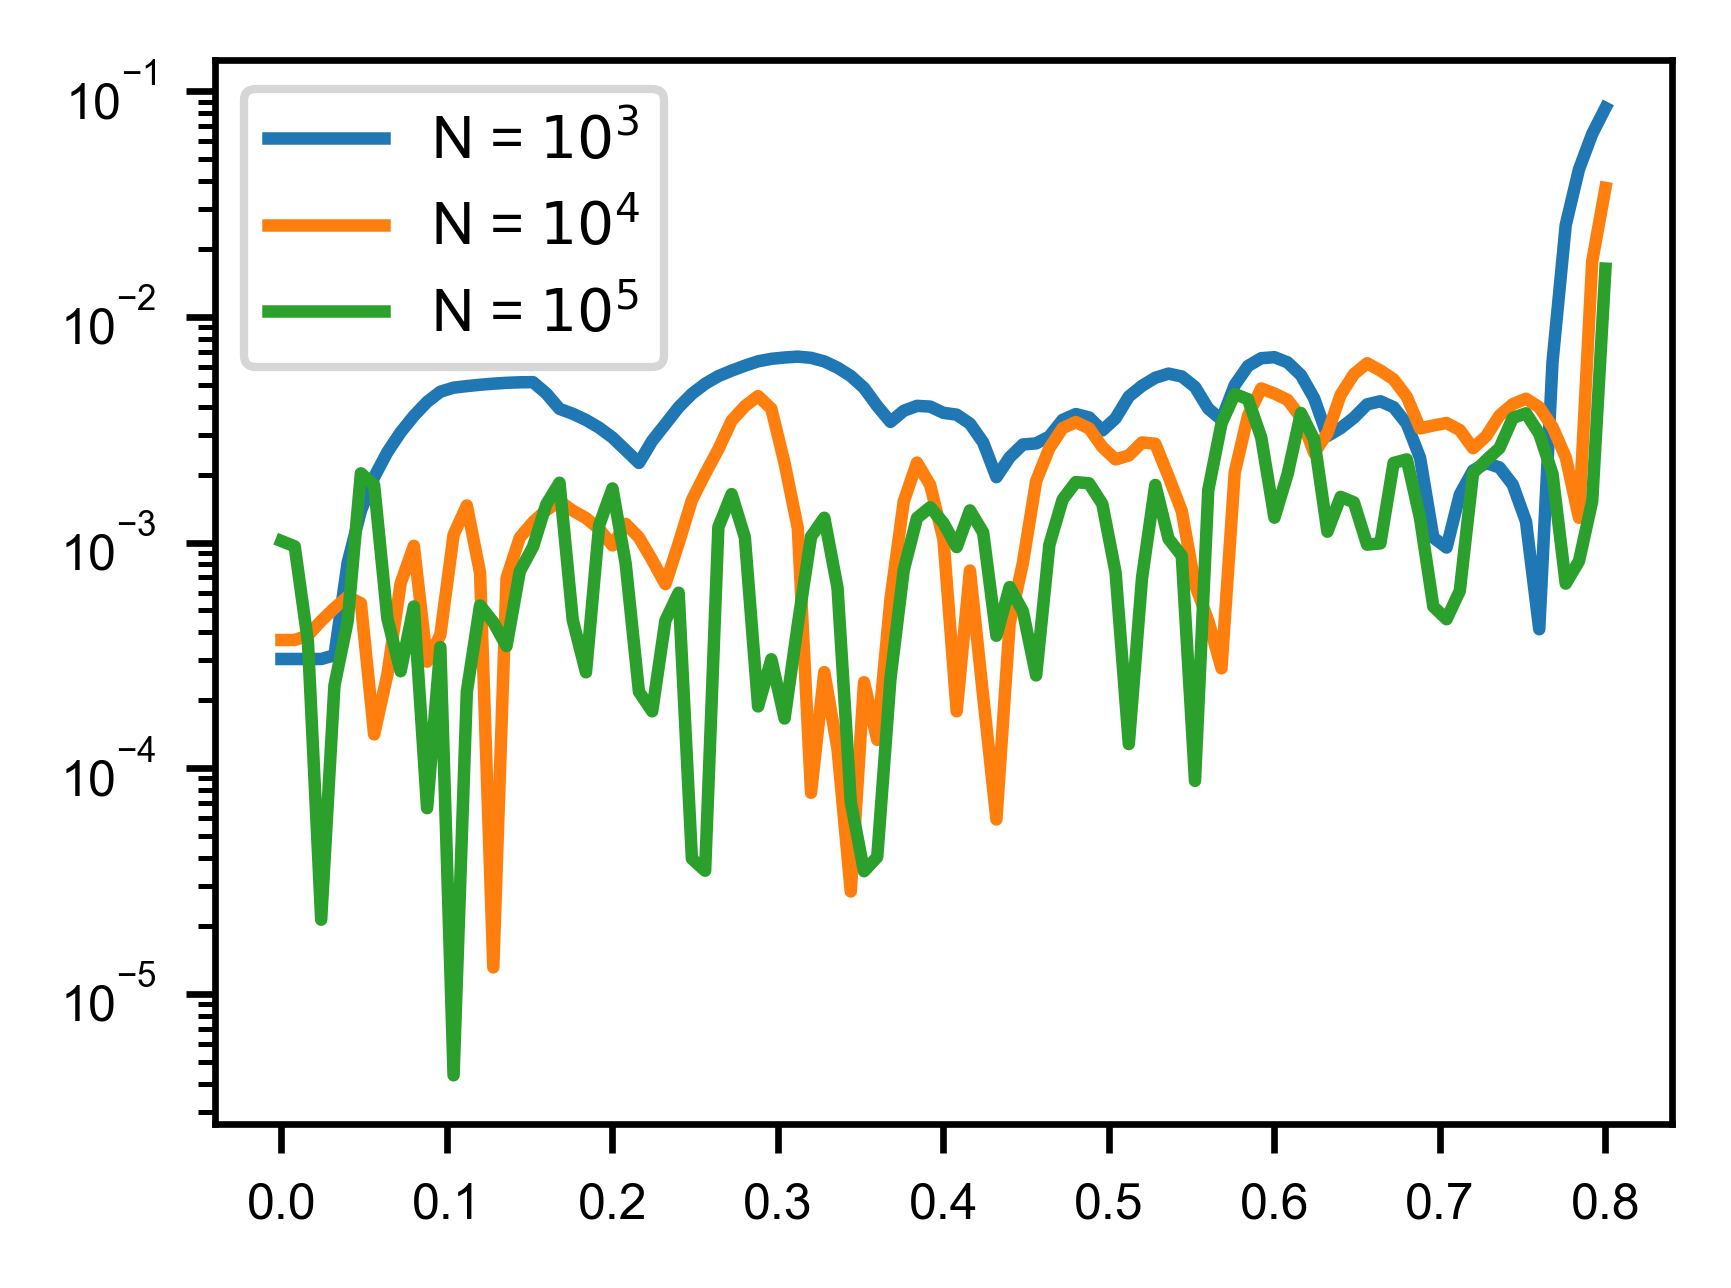

In [62]:
for i, (N_boot, N_traj_per_boot) in enumerate(Nboot_Ntraj):
    err_ave = err_aves[i][var_pair[0].name]
#     err_std = err_stds[i][var_pair[0].name]
    plt.plot(err_t, np.abs(err_ave), label=f'N = $10^{np.log10(N_traj_per_boot).astype(int)}$')
plt.yscale('log')
plt.legend()

## $L^2$ Consistency Check

In [43]:
importlib.reload(fw.simulation)
importlib.reload(fw)


<module 'multi_locus_analysis.finite_window' from '/home/bbeltr1/developer/multi_locus_analysis/multi_locus_analysis/finite_window/__init__.py'>

In [44]:
var_pair = variable_pairs['beta']
T = windows['beta']

In [ ]:
%%time
N_boot = 100
N_traj = np.logspace(3, 5, 10)
err_aves = []
err_stds = []
err_l2s = []
for Nt in N_traj:
    err_t, err_ave, err_std, err_l2 = fw.bootstrap_int_error(
        var_pair, T, N_boot, int(Nt)
    )
    err_aves.append(err_ave)
    err_stds.append(err_std)
    err_l2s.append(err_l2)

In [33]:
l2_errs = {var.name: np.sum([err[var.name] for err in err_l2s], axis=1) for var in var_pair}

In [26]:
l2_errs = {var.name: [err[var.name] for err in err_l2s] for var in var_pair}

In [29]:
np.sum(np.array(l2_errs[var.name]), axis=1).shape

(10,)

In [37]:
for var in var_pair:
    print(scipy.stats.linregress(np.log10(N_traj), np.log10(l2_errs[var.name])))

LinregressResult(slope=-0.4956800432745958, intercept=2.046961346305419, rvalue=-0.9953345613607071, pvalue=2.0611732333395084e-09, stderr=0.01698796898707596, intercept_stderr=0.06881156583595566)
LinregressResult(slope=-0.48281496884251335, intercept=1.8454370710938945, rvalue=-0.9750150784162829, pvalue=1.6542802227351753e-06, stderr=0.03889095465026976, intercept_stderr=0.1575319267639441)


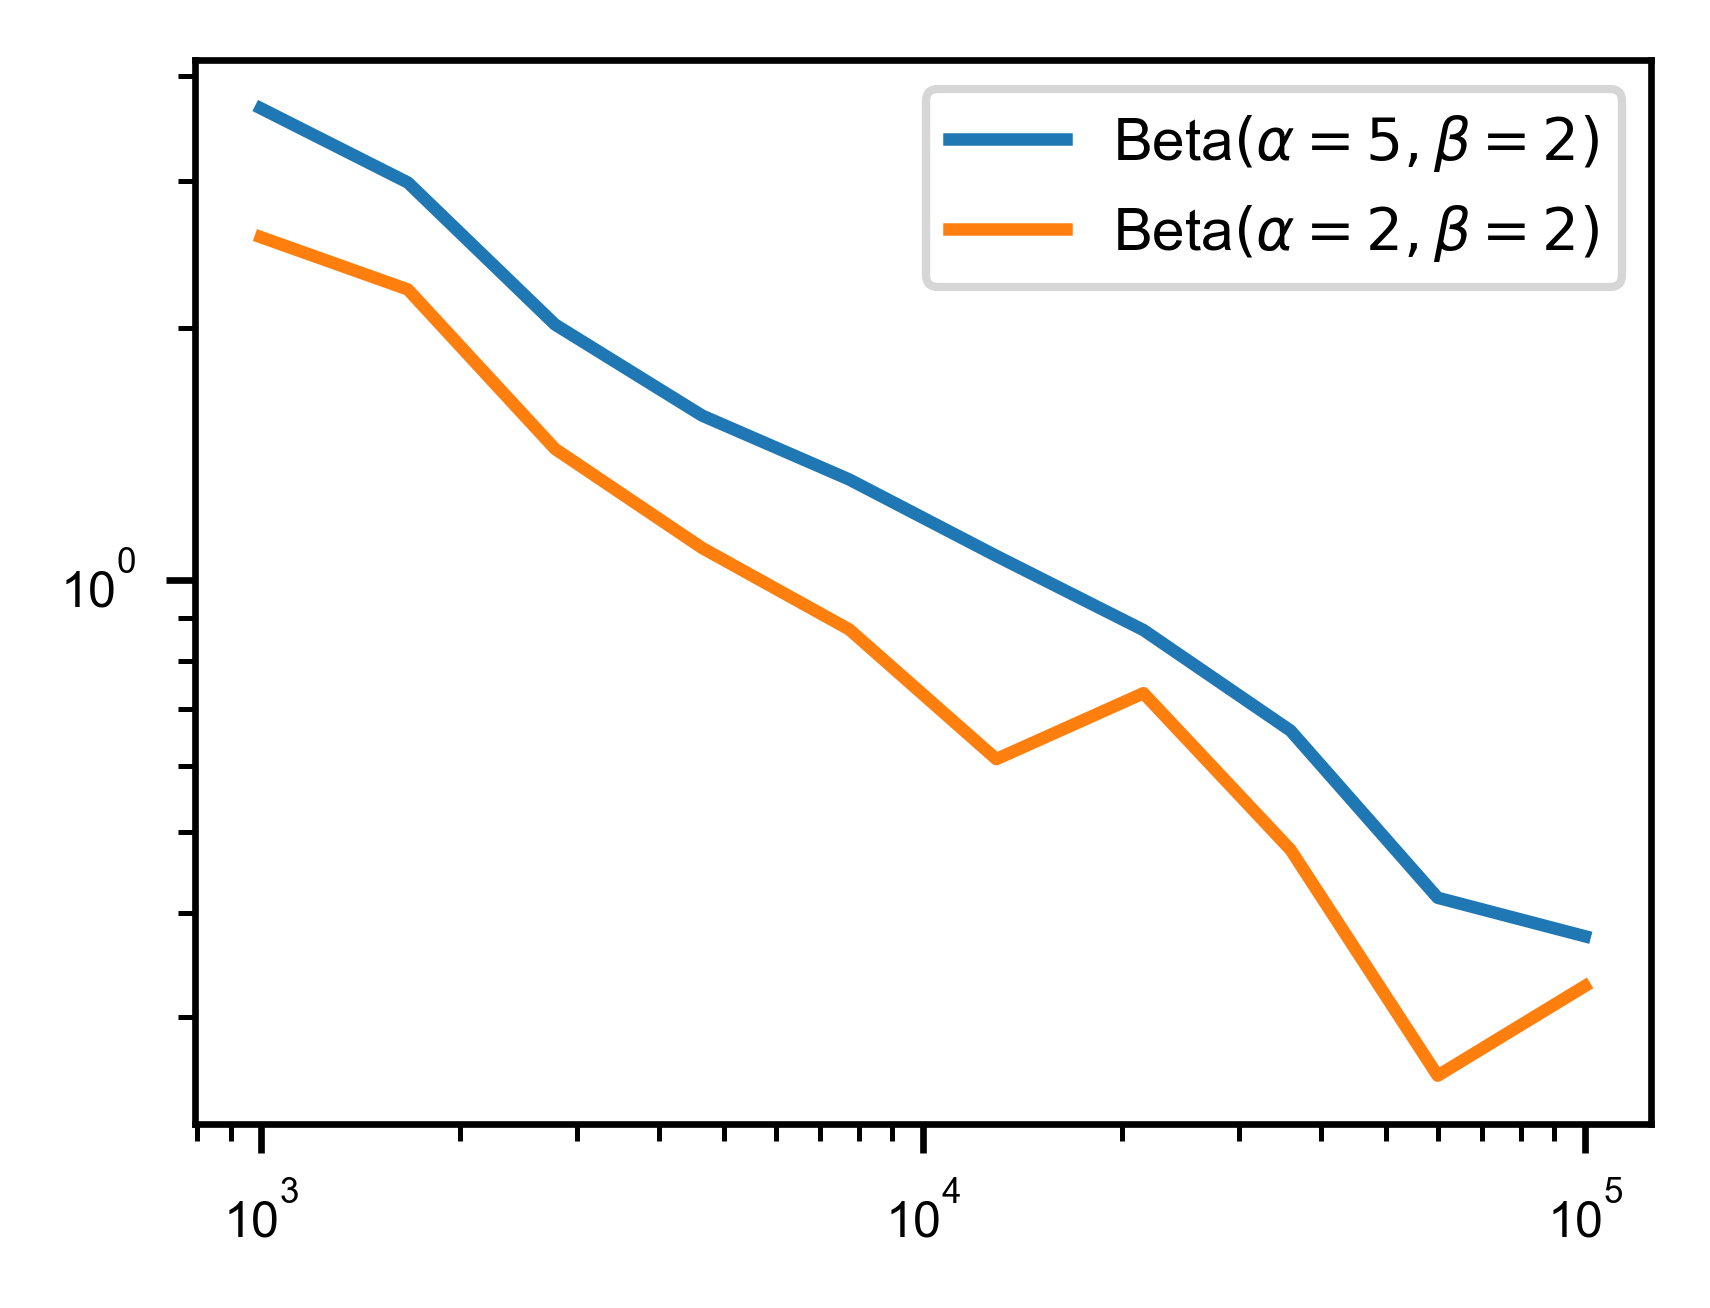

In [40]:
for var in var_pair:
    plt.plot(N_traj, l2_errs[var.name], label=var.pretty_name)
plt.xscale('log')
plt.yscale('log')
plt.legend()

## Old runs

large number of bootstraps...

In [47]:
import pickle

In [50]:
with open('/home/bbeltr1/Downloads/int_err_boot_1000_traj.pkl', 'wb') as f:
    pickle.dump((err_ave, err_std), f)

In [70]:
with open('/home/bbeltr1/Downloads/int_err_boot_1000_traj.pkl', 'rb') as f:
    err_ave, err_std = pickle.load(f)

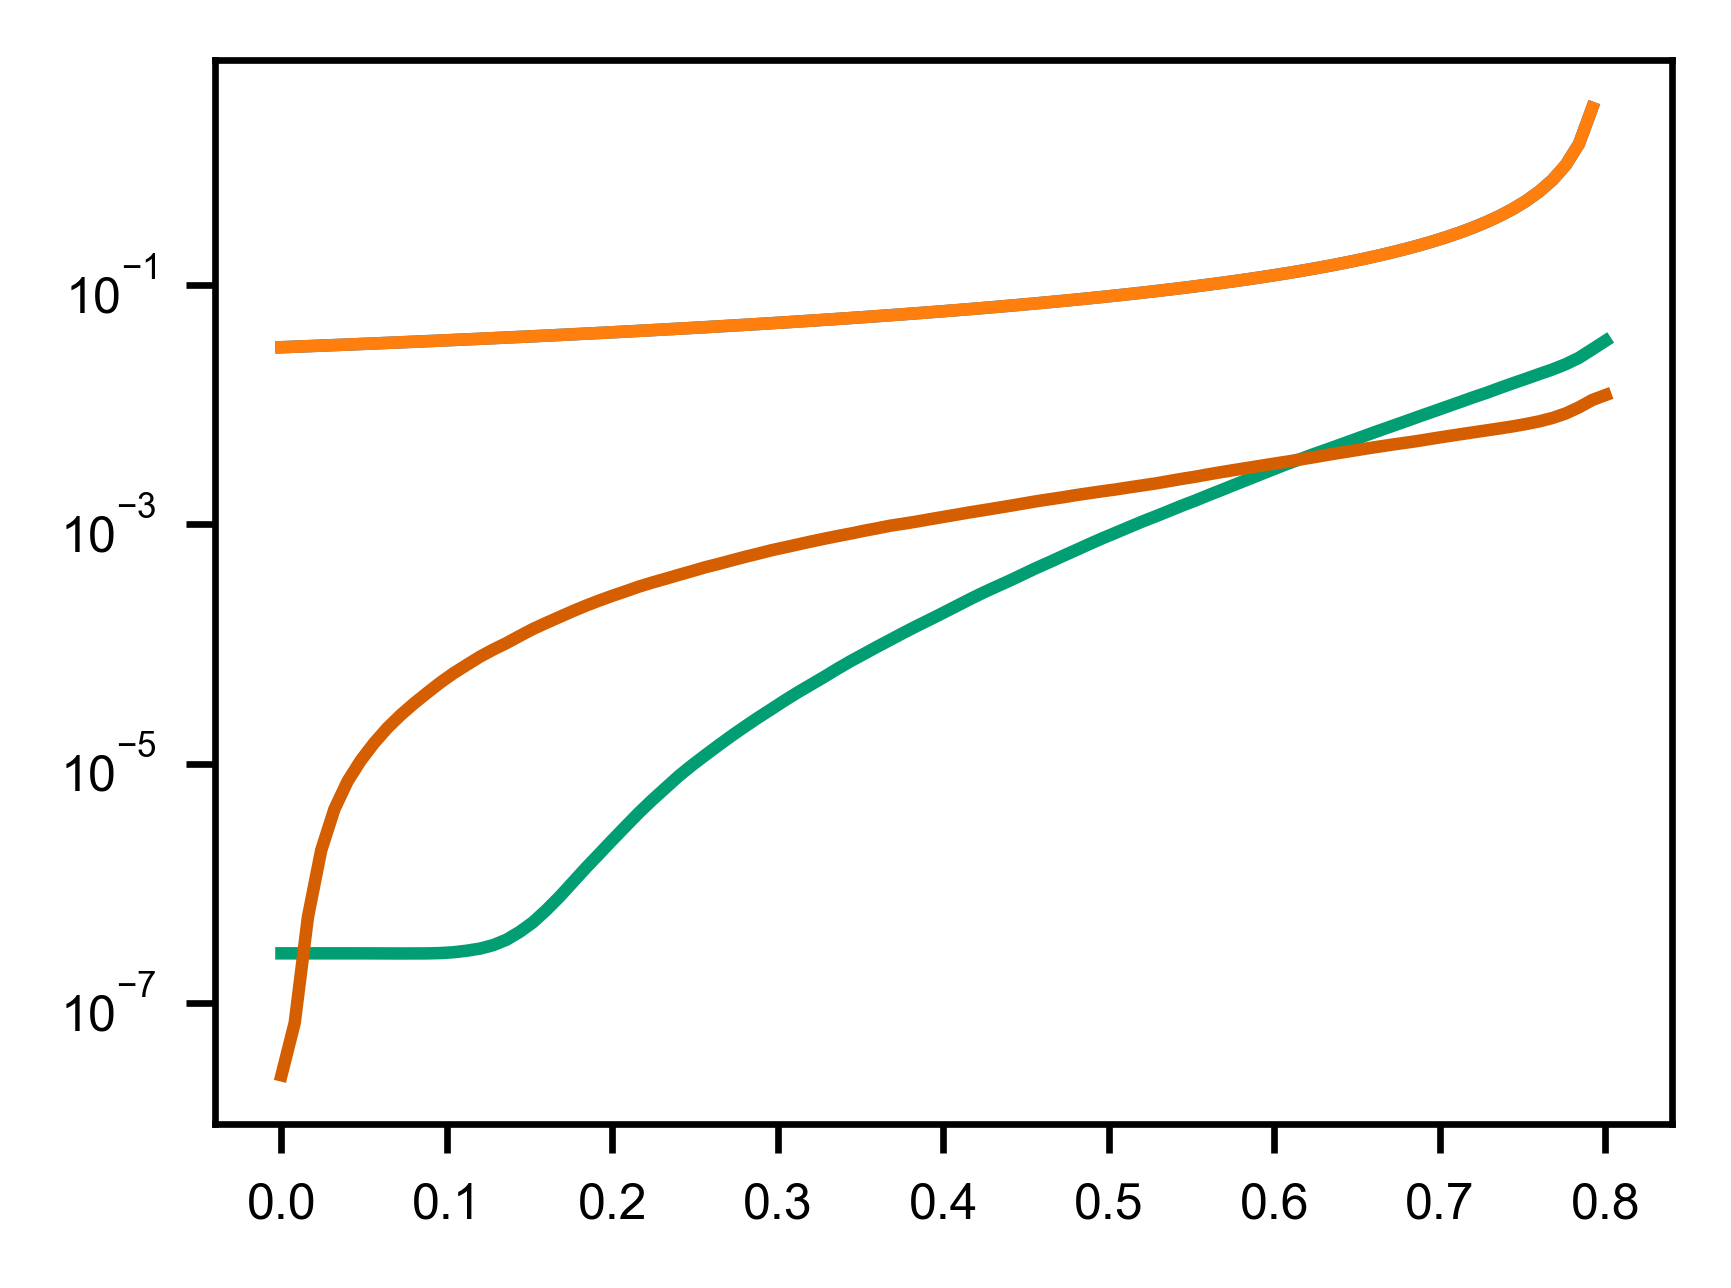

In [80]:
for var in var_pair:
    plt.plot(err_t, err_std[var.name], color=var.color)
    plt.plot(err_t, dfw_e*T/(T - err_t))
    plt.yscale('log')


(0.0001, 0.1)

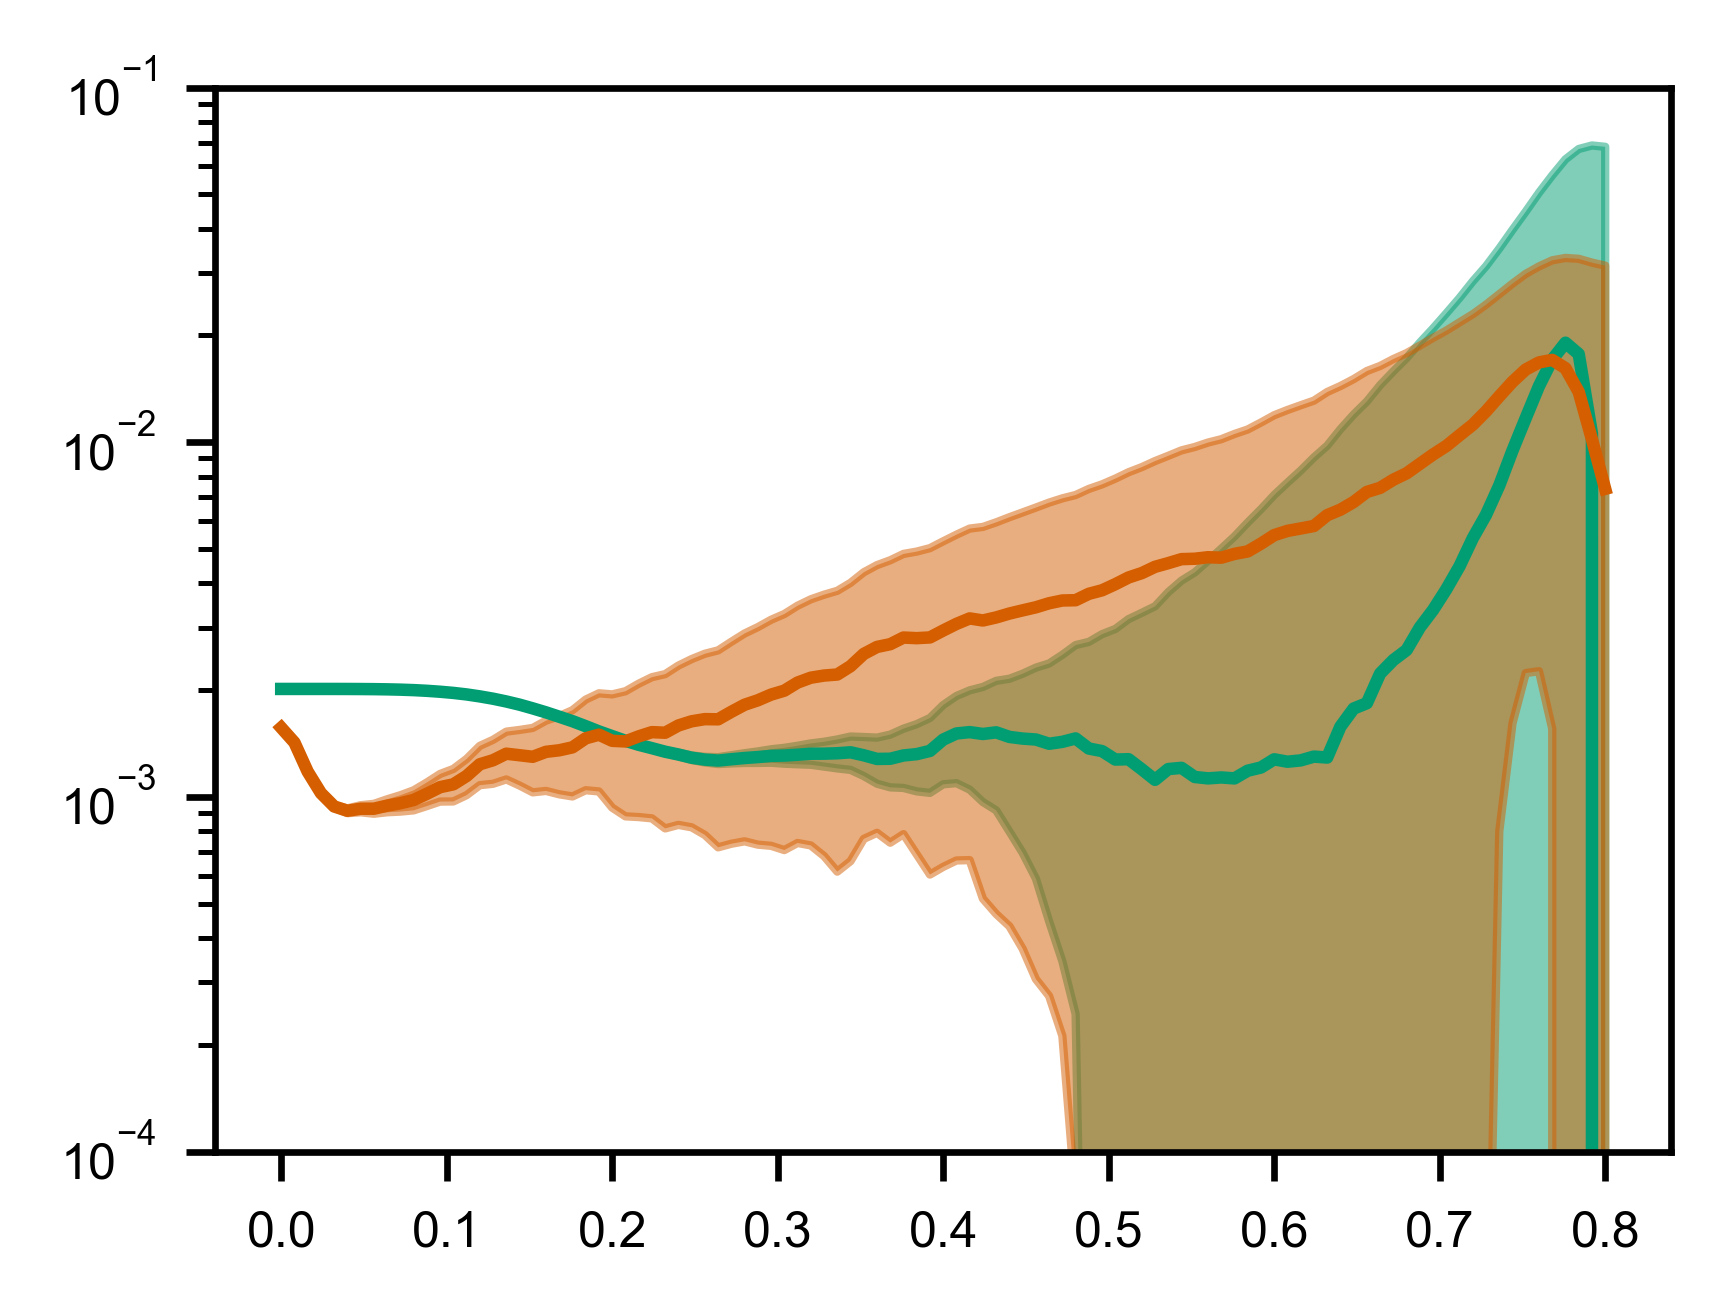

In [71]:
fig, ax = plt.subplots()
for var in var_pair:
    ax.plot(err_t, -err_ave[var.name], c=var.color)
    ax.fill_between(
        err_t, 
        -err_ave[var.name] - 2*err_std[var.name],
        -err_ave[var.name] + 2*err_std[var.name],
        alpha=0.5,
        color=var.color
    )
plt.yscale('log')
plt.ylim([1e-4, 1e-1])

In [85]:
observation = fw.sim_to_obs(sim)

In [96]:
N_per_subboot = 1000
replicates = observation.index.get_level_values('replicate').unique().values
num_replicates = len(replicates)
obs = observation.reset_index(level=1).loc[np.random.randint(num_replicates, size=(N_per_subboot,))]

In [97]:
obs

,rank_order,state,start_time,end_time,wait_time,window_size,num_waits,wait_type
replicate,,,,,,,,
120,1,"Beta(2, 2)",0.000000,0.263928,0.263928,0.8,2,left exterior
120,2,"Beta(5, 2)",0.263928,0.800000,0.536072,0.8,2,right exterior
288,1,"Beta(5, 2)",0.000000,0.338358,0.338358,0.8,3,left exterior
288,2,"Beta(2, 2)",0.338358,0.502808,0.164450,0.8,3,interior
288,3,"Beta(5, 2)",0.502808,0.800000,0.297192,0.8,3,right exterior
...,...,...,...,...,...,...,...,...
401,1,"Beta(2, 2)",0.000000,0.449426,0.449426,0.8,2,left exterior
401,2,"Beta(5, 2)",0.449426,0.800000,0.350574,0.8,2,right exterior
972,1,"Beta(2, 2)",0.000000,0.714282,0.714282,0.8,2,left exterior


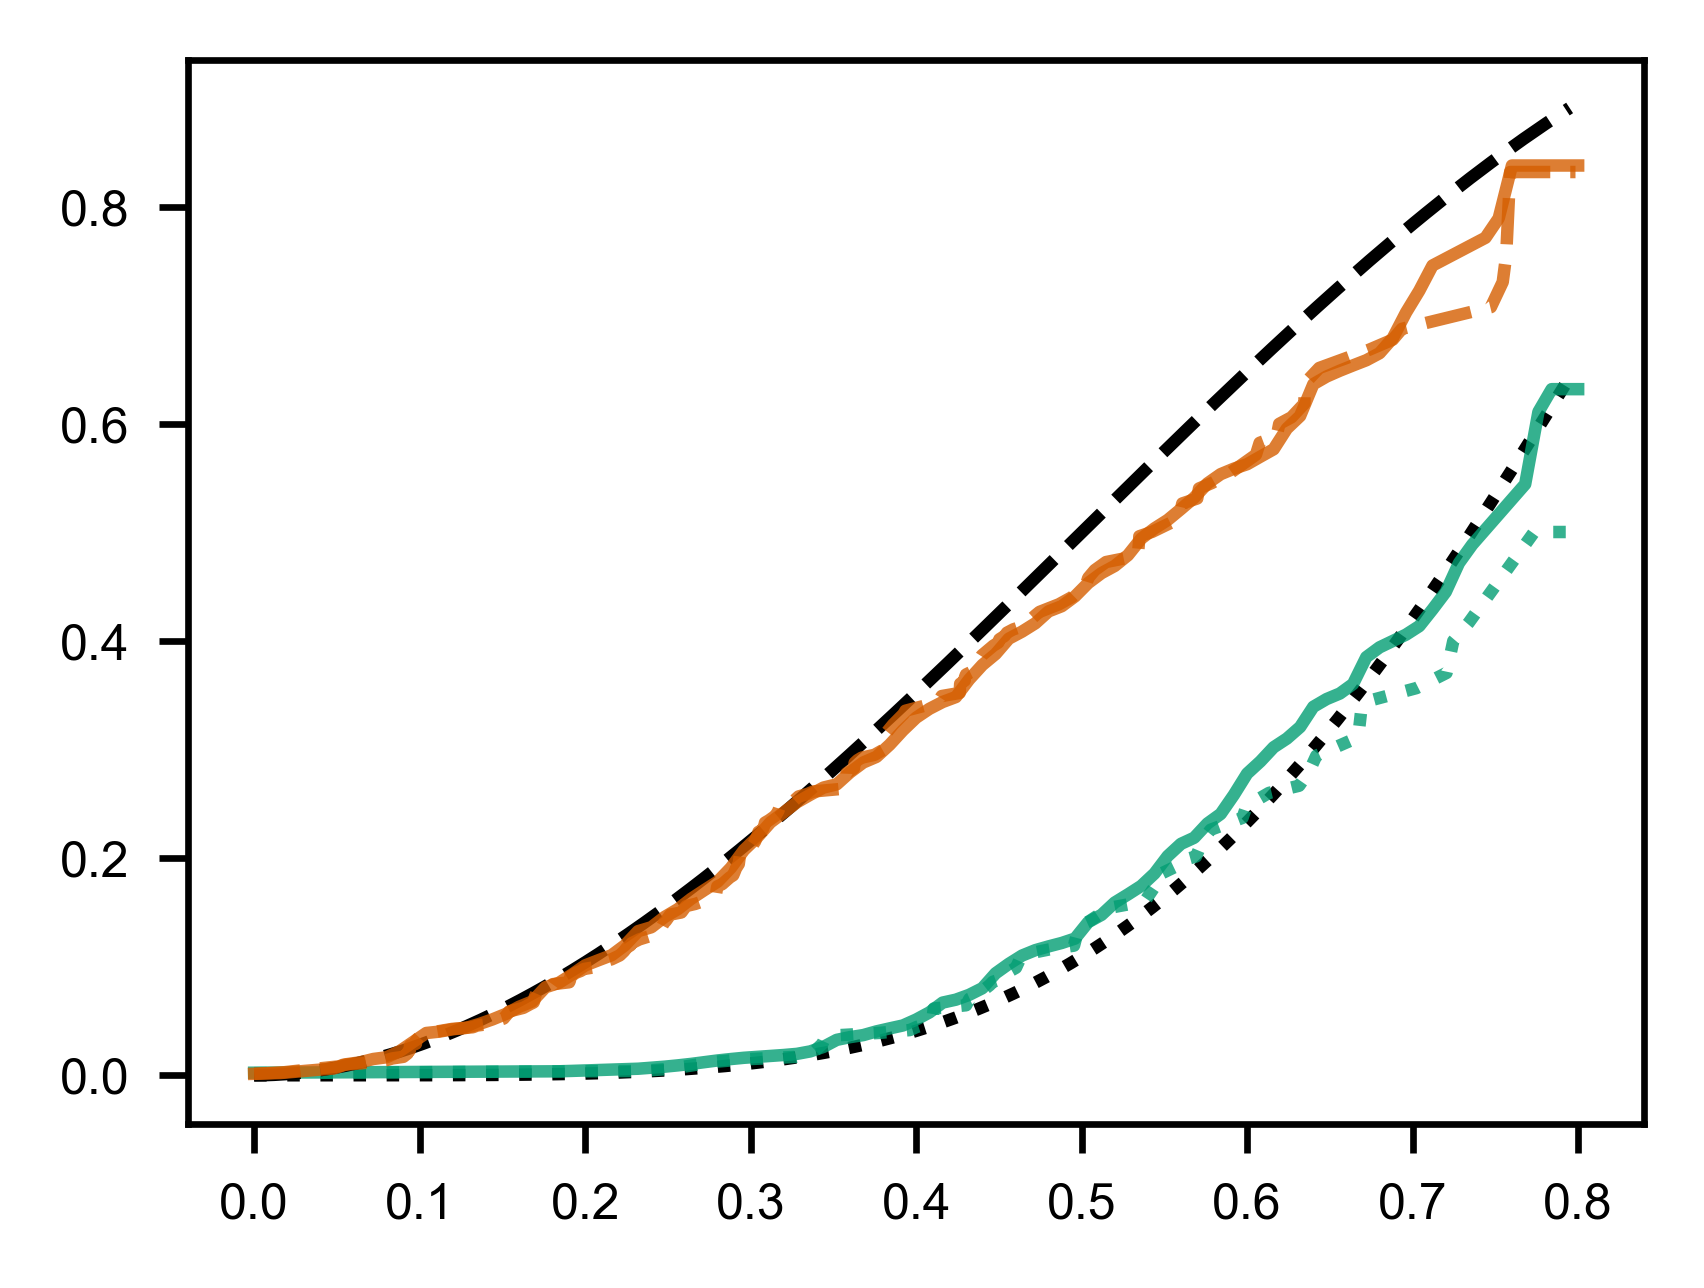

In [101]:
stats = mla.stats
traj_cols = ['replicate']
sim = fw.ab_window(
    [var.rvs for var in var_pair],
    offset=-100*np.sum([var.mean() for var in var_pair]),
    window_size=T, 
    num_replicates=1_000,  
    states=[var.name for var in var_pair]
)
observation = fw.sim_to_obs(sim)

shared_t = np.linspace(0, T, 101)
est = {var.name: np.zeros_like(shared_t) for var in var_pair}
saved_all_times = {}
saved_int_est = {}
N_subboot = 100
N_per_subboot = 1000

for i in range(N_subboot):
    replicates = observation.index \
        .get_level_values('replicate').unique().values
    num_replicates = len(replicates)
    obs = observation.reset_index(level=1) \
        .loc[np.random.randint(num_replicates, size=(N_per_subboot,))]
    for var in var_pair:
        interior = obs.loc[
            (obs['state'] == var.name) & (obs['wait_type'] == 'interior'),
            ['wait_time', 'window_size']
        ].copy()
        exterior = obs.loc[
                (obs['state'] == var.name)
                & (obs['wait_type'] != 'interior')
                & (obs['wait_type'] != 'full exterior'),
                ['wait_time', 'window_size']
        ].copy()
        window_sizes = obs.groupby(traj_cols)['window_size'].first().values
        # now sorted
        window_sizes, window_cdf = stats.ecdf(window_sizes)
        window_sf = 1 - window_cdf
        all_times, cdf_int, cdf_ext, Z_X, F_T = fw.ecdf_ext_int(
            exterior.wait_time.values,
            interior.wait_time.values,
            interior.window_size.values
        )
        est[var.name] += (1/N_subboot) * np.interp(shared_t, all_times, cdf_int*F_T) 
        if i == 0:
            saved_all_times[var.name] = all_times
            saved_int_est[var.name] = cdf_int*F_T

        
fig, ax = plt.subplots()
for var in var_pair:
    line, = ax.plot(all_times, var.cdf(all_times), ls=var.linestyle,
                    c='k', label=f'True $F_X(t)$')
    line, = ax.plot(saved_all_times[var.name], saved_int_est[var.name], c=var.color, ls=var.linestyle, alpha=0.8,
                    label='Interior CDF estimate')
    line, = ax.plot(shared_t, est[var.name], c=var.color, alpha=0.8,
                    label='Bootstrap CDF estimate')

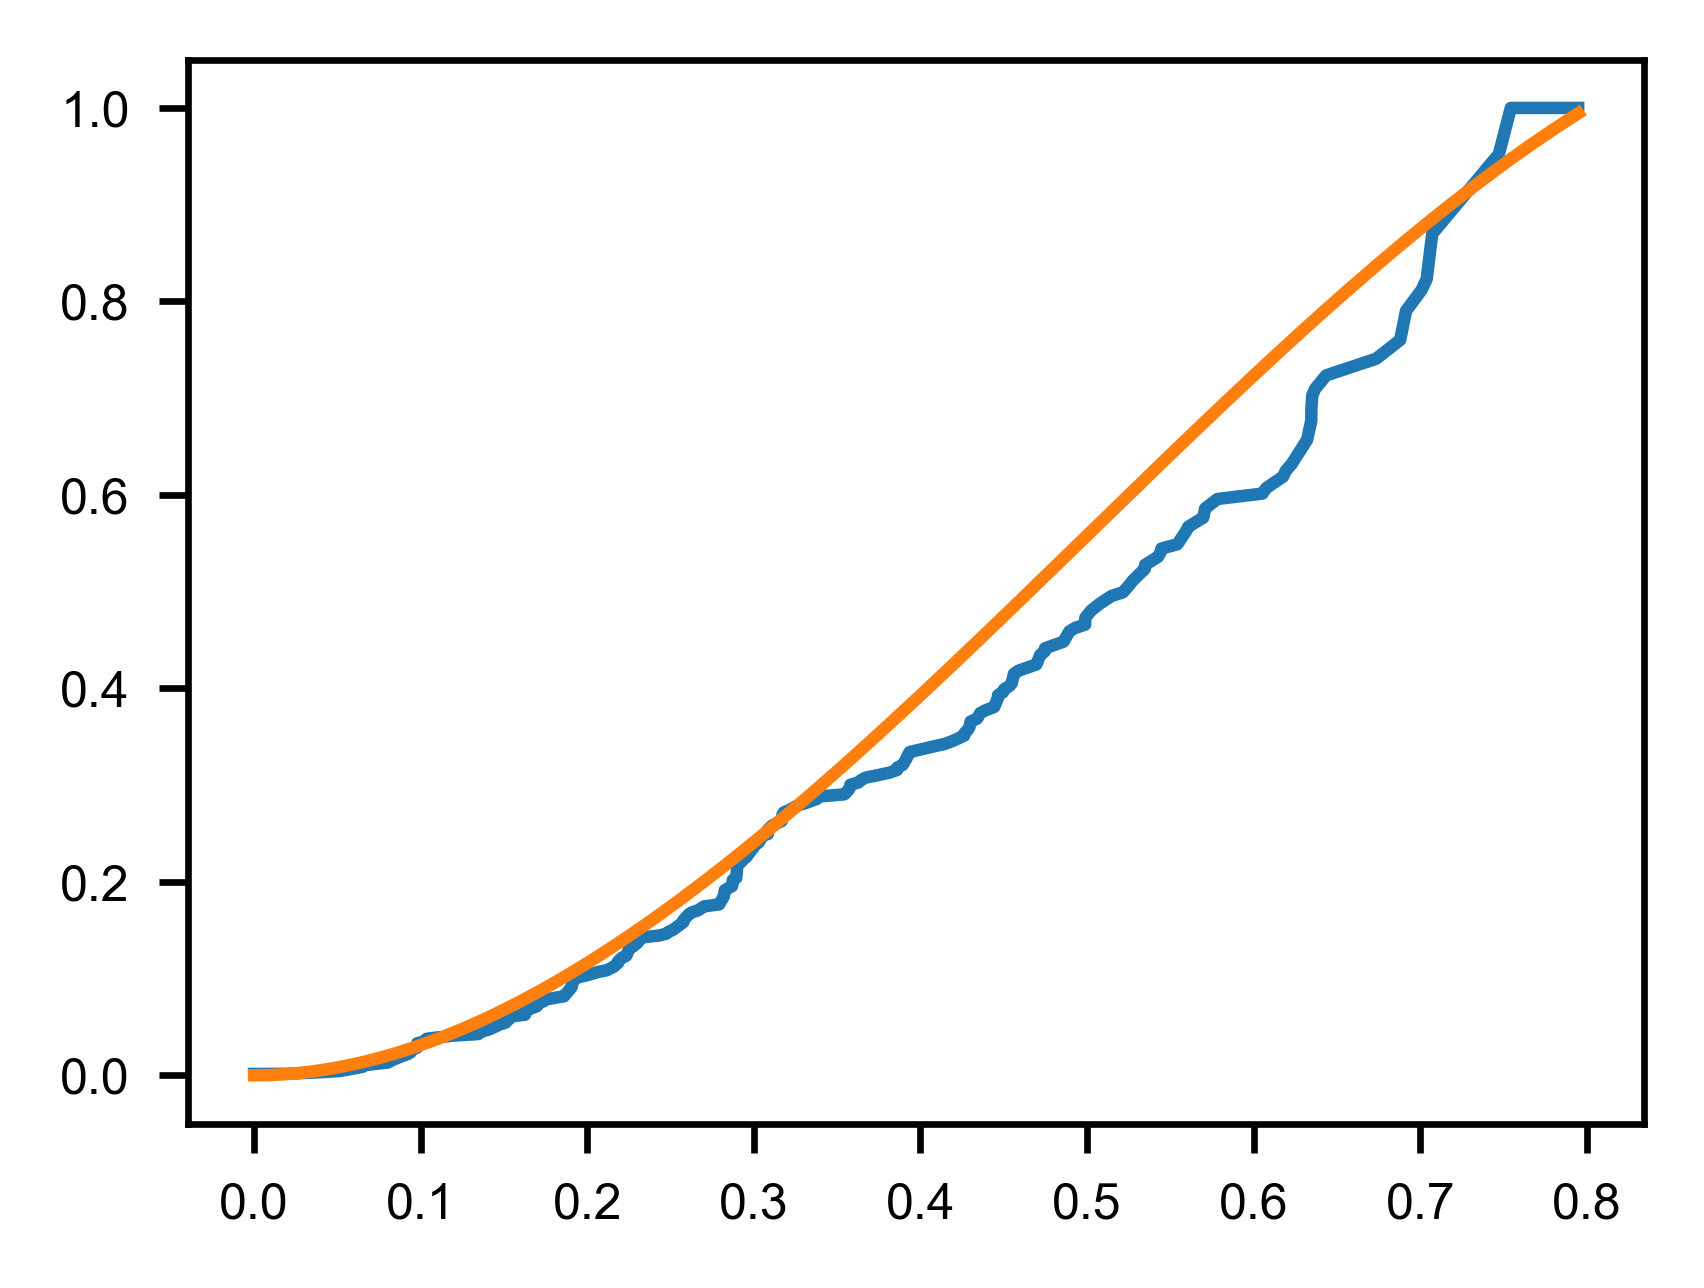

In [103]:
plt.plot(all_times, cdf_int)
plt.plot(all_times, var.cdf(all_times) / var.cdf(T))